In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import itertools
import warnings

!pip install pmdarima
import pmdarima as pm

In [2]:
df = pd.read_csv('C:/Users/ameyr/Documents/Alex Documents/Machine Learning Class/Month 1/Module 11/practical_application_II_starter/data/vehicles.csv')

In [3]:
##Drop columns that are not relevant to local car dealers in understanding the price at which they may sell their cars or should be looking to buy cars
df = df.drop(columns=['VIN','model','region','paint_color','state','id'])

In [4]:
##turn condition into a float value
df['condition_score'] = df['condition'].replace({
    'new': 5,
    'like new': 4,
    'excellent': 3,
    'good': 2,
    'fair': 1,
    'salvage': 0})

##turn cylinders into a float value
df['cylinders_count'] = df['cylinders'].replace({
    '8 cylinders':8,
    '6 cylinders':6,
    '4 cylinders':4,
    '5 cylinders':5,
    'other':0,
    '3 cylinders':3,
    '10 cylinders':10,
    '12 cylinders':12})

##for cars with null values for cylinders/odometer/age/condition, just assume they have the median number of cylinders. and turn the car year into an age
df['cylinders_count'].fillna(df['cylinders_count'].median(), inplace=True)
df['odometer'].fillna(df['odometer'].median(), inplace=True)
df['age'] = 2025 - df['year']
df['age'].fillna(df['age'].median(), inplace=True)
df['condition_score'].fillna(df['condition_score'].median(), inplace=True)


C:\Users\ameyr\AppData\Local\Temp\ipykernel_3748\3662797907.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['condition_score'] = df['condition'].replace({
C:\Users\ameyr\AppData\Local\Temp\ipykernel_3748\3662797907.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cylinders_count'] = df['cylinders'].replace({
C:\Users\ameyr\AppData\Local\Temp\ipykernel_3748\3662797907.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

In [5]:
##Replace the nulls in fuel, transmission, drive and type with the most common variables in those columns rather than removing all these nulls
for col in ['fuel', 'transmission', 'drive', 'type']:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\ameyr\AppData\Local\Temp\ipykernel_3748\4065445132.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [6]:
##drop categorical columns that have been turned into float columns
df_cleaned = df.drop(columns = ['year','cylinders','condition','size'])

## split title_status into 1 for clean and 0 for all others
df_cleaned['title_status_num'] = df['title_status'].replace({
    'clean':1})
df_cleaned['title_status_num'].fillna(0, inplace=True)

## drop nulls
df_cleaned = df_cleaned.dropna()

C:\Users\ameyr\AppData\Local\Temp\ipykernel_3748\4143536204.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['title_status_num'].fillna(0, inplace=True)


In [7]:
##understand which features are still skewed
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64'])
skewness = numeric_cols.skew().sort_values(ascending=False)
print(skewness)

price              246.897000
odometer            40.394796
age                  3.605044
condition_score      1.263514
cylinders_count     -0.117491
dtype: float64


In [8]:
##Remove cars that are outliers according to their price
Q1 = df_cleaned['price'].quantile(0.25)
Q3 = df_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1

# Keep only non-outliers
df_cleaned = df_cleaned[(df_cleaned['price'] >= Q1 - 1.5 * IQR) & 
                        (df_cleaned['price'] <= Q3 + 1.5 * IQR)]

In [9]:
##Remove cars that are outliers according to their age
Q1 = df_cleaned['age'].quantile(0.25)
Q3 = df_cleaned['age'].quantile(0.75)
IQR = Q3 - Q1

# Keep only non-outliers
df_cleaned = df_cleaned[(df_cleaned['age'] >= Q1 - 1.5 * IQR) & 
                        (df_cleaned['age'] <= Q3 + 1.5 * IQR)]

In [10]:
##Remove cars that are outliers according to their odometer
Q1 = df_cleaned['odometer'].quantile(0.25)
Q3 = df_cleaned['odometer'].quantile(0.75)
IQR = Q3 - Q1

# Keep only non-outliers
df_cleaned = df_cleaned[(df_cleaned['odometer'] >= Q1 - 1.5 * IQR) & 
                        (df_cleaned['odometer'] <= Q3 + 1.5 * IQR)]

In [12]:
## Turn Categorical columns into Individual columns
df_final = pd.get_dummies(df_cleaned, drop_first=True)

In [13]:
##Create Train and Test split with the Target Variable (Price)
from sklearn.model_selection import train_test_split

X = df_final.drop(columns='price')
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
##Build a linear Regression model and calculate MSE and R-squared
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 89475816.0855627
R²: 0.4803534590951586


In [27]:
##Build a RandomForestRegressor model and calculate MSE and R-squared
print("Starting model training...")


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop(columns='price')
y = df_final['price']  # use raw price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Random Forest MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
print("Done!")

Starting model training...
Random Forest MSE: 35752833.53502956
R²: 0.7923591302452229
Done!


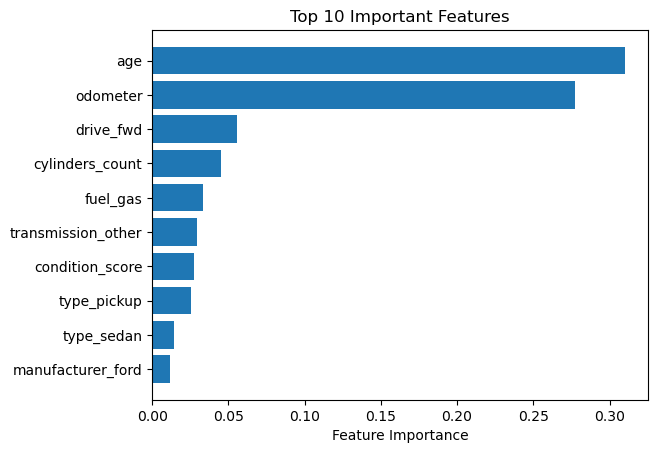

In [31]:
##Identify feature importance for the RandomForest Model
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns

# Plot top 10
top_indices = importances.argsort()[-10:]
plt.barh(range(10), importances[top_indices], align='center')
plt.yticks(range(10), features[top_indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()

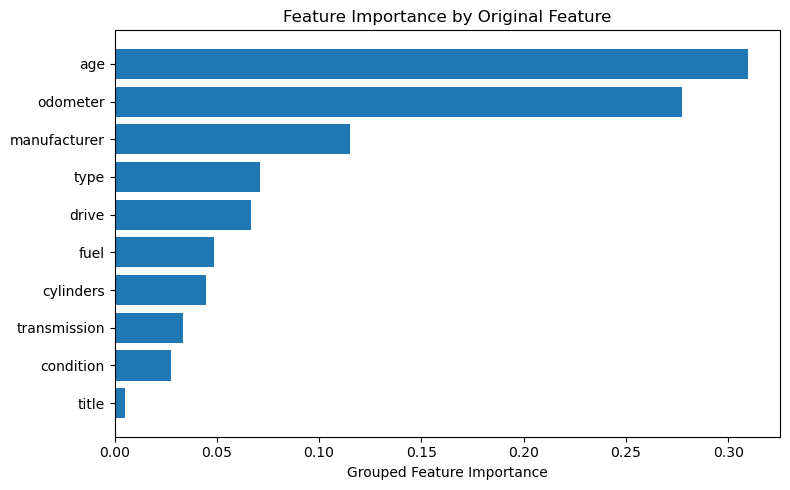

In [33]:
##Identify important features for RandomForest Model but this time rejoin back up the categorical features
all_feature_names = X.columns

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Group by original feature (before one-hot)
grouped_importance = defaultdict(float)

for name, importance in zip(all_feature_names, rf.feature_importances_):
    group = name.split('_')[0]  # For one-hot columns like 'fuel_diesel', this gets 'fuel'
    grouped_importance[group] += importance

# Convert to DataFrame and plot
grouped_df = pd.DataFrame(grouped_importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(grouped_df['Feature'], grouped_df['Importance'])
plt.xlabel("Grouped Feature Importance")
plt.title("Feature Importance by Original Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

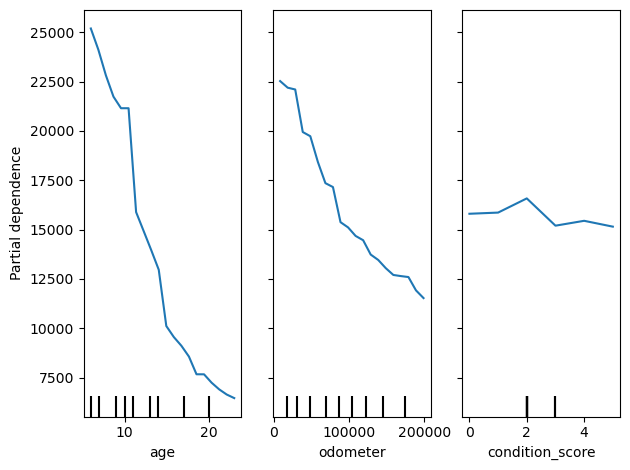

In [61]:
from sklearn.inspection import PartialDependenceDisplay

# Show top features (e.g. 'age', 'odometer', 'condition_score')
features_to_plot = ['age', 'odometer', 'condition_score']

PartialDependenceDisplay.from_estimator(rf, X, features_to_plot, kind='average', grid_resolution=20)
plt.tight_layout()
plt.show()

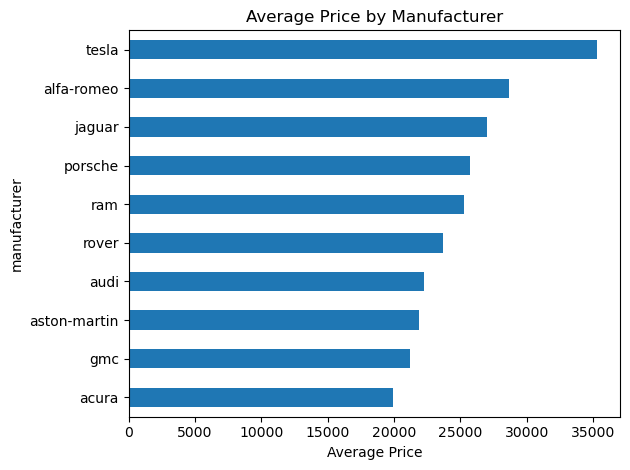

In [82]:
df_cleaned.groupby('manufacturer')['price'].mean().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Average Price by Manufacturer")
plt.xlabel("Average Price")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

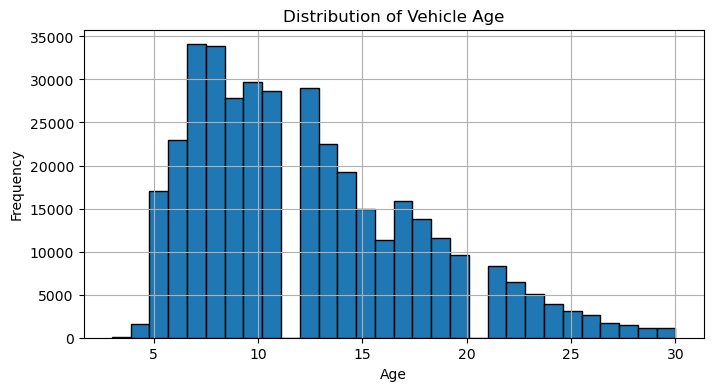

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['age'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Vehicle Age')
plt.grid(True)
plt.show()

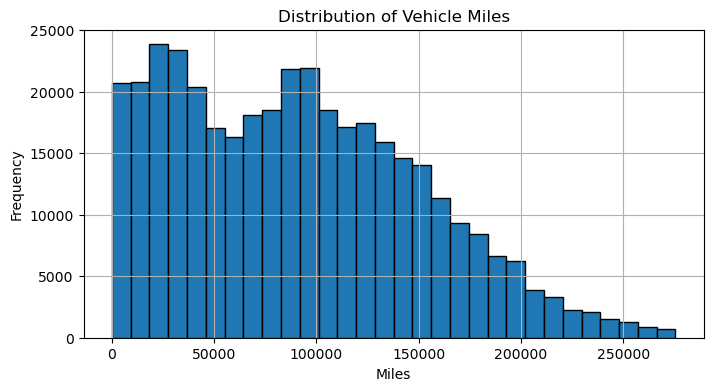

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['odometer'], bins=30, edgecolor='black')
plt.xlabel('Miles')
plt.ylabel('Frequency')
plt.title('Distribution of Vehicle Miles')
plt.grid(True)
plt.show()

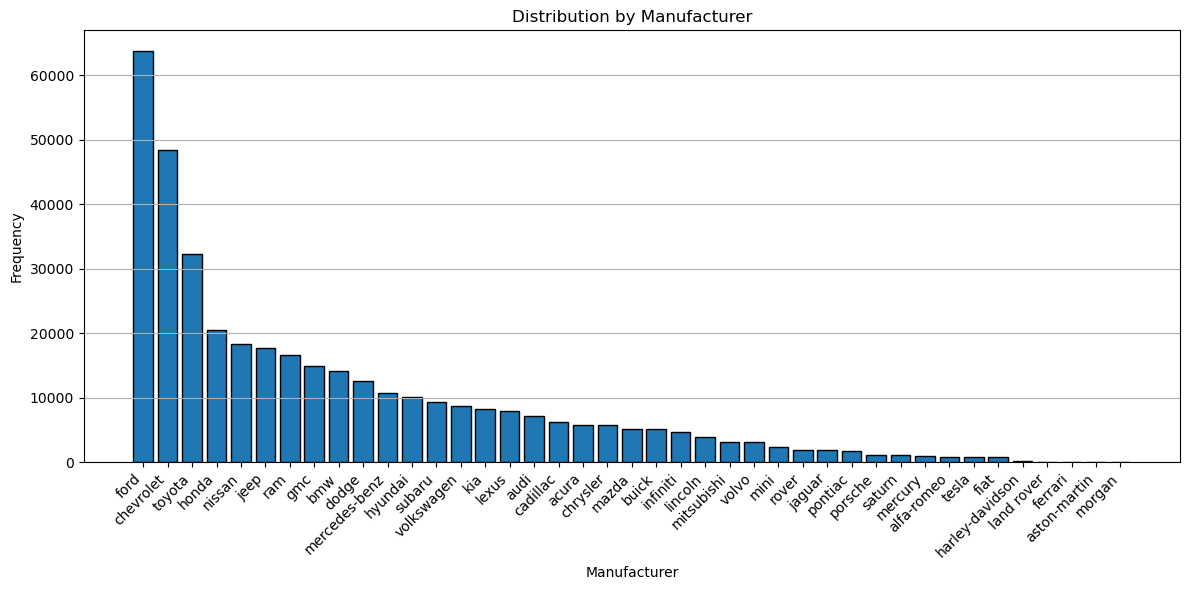

In [55]:
import matplotlib.pyplot as plt

# Count each manufacturer
manufacturer_counts = df_cleaned['manufacturer'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(manufacturer_counts.index, manufacturer_counts.values, edgecolor='black')
plt.xlabel('Manufacturer')
plt.ylabel('Frequency')
plt.title('Distribution by Manufacturer')
plt.xticks(rotation=45, ha='right')  # Rotate for readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()

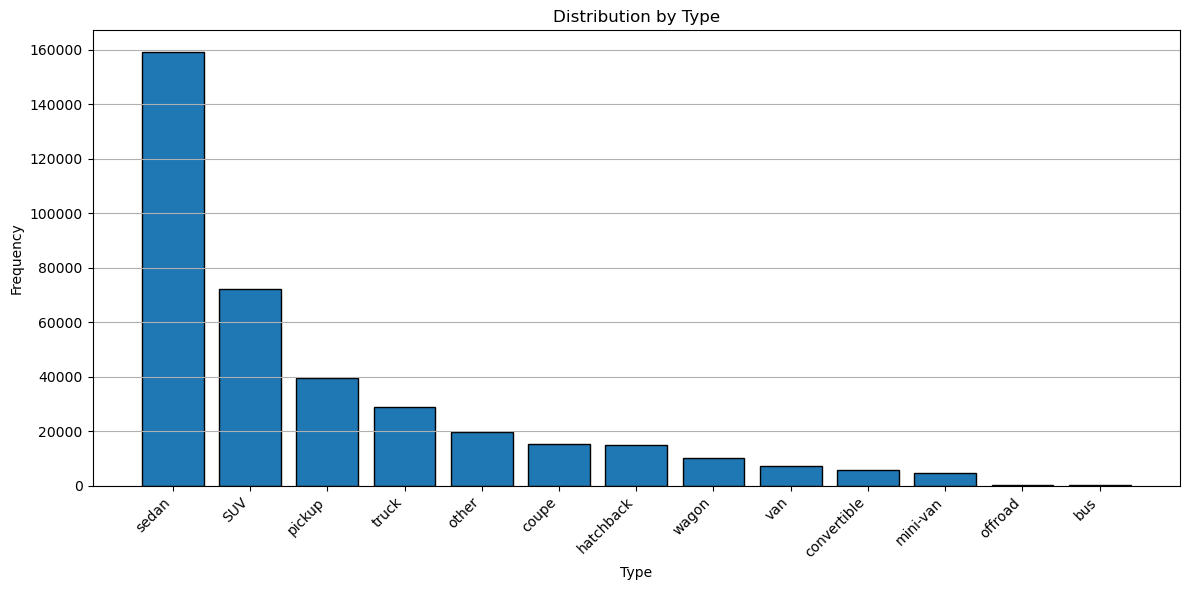

In [57]:
import matplotlib.pyplot as plt

# Count each manufacturer
type_counts = df_cleaned['type'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(type_counts.index, type_counts.values, edgecolor='black')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.title('Distribution by Type')
plt.xticks(rotation=45, ha='right')  # Rotate for readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()

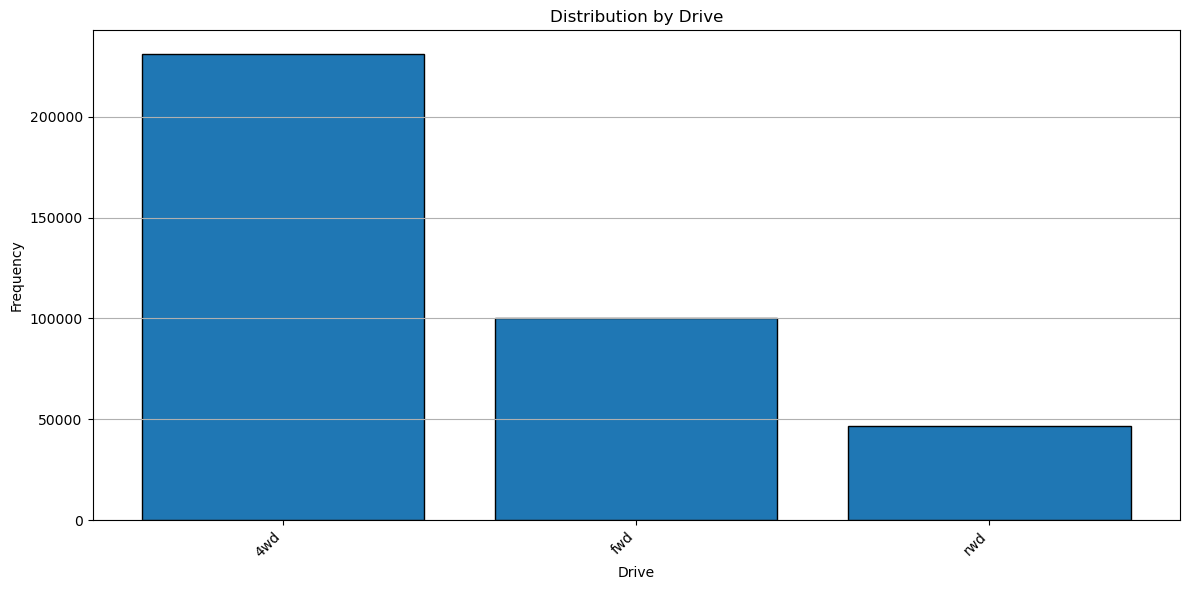

In [59]:
import matplotlib.pyplot as plt

# Count each manufacturer
drive_counts = df_cleaned['drive'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(drive_counts.index, drive_counts.values, edgecolor='black')
plt.xlabel('Drive')
plt.ylabel('Frequency')
plt.title('Distribution by Drive')
plt.xticks(rotation=45, ha='right')  # Rotate for readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()

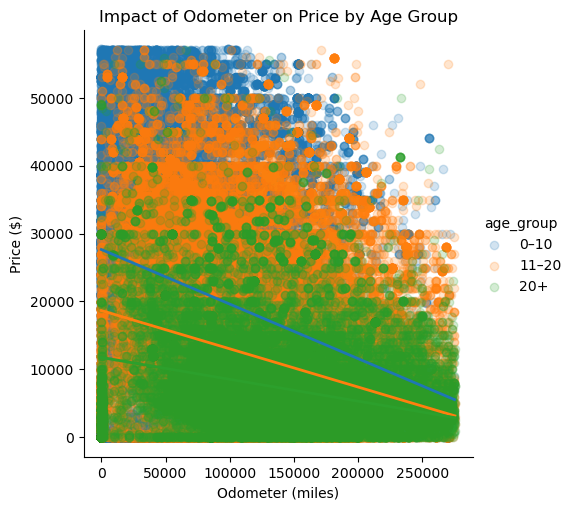

In [75]:
import seaborn as sns

# Create age groups
df_final['age_group'] = pd.cut(df_final['age'], bins=[0, 10, 20, 100], labels=['0–10','11–20','20+'])

# Plot odometer vs. price, colored by age group
sns.lmplot(data=df_final, x='odometer', y='price', hue='age_group', scatter_kws={'alpha':0.2}, line_kws={'linewidth':2})
plt.title("Impact of Odometer on Price by Age Group")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price ($)")
##plt.tight_layout()
plt.show()

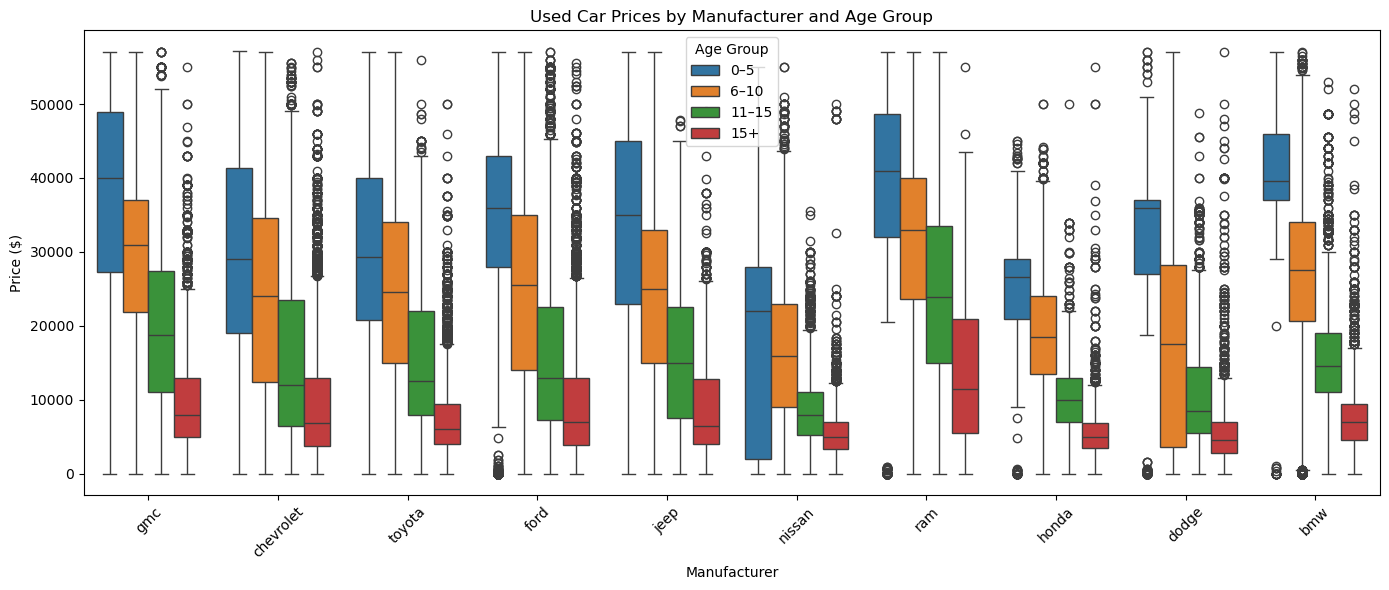

In [98]:
# Bin age into ranges
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[0, 5, 10, 15, 100], labels=['0–5', '6–10', '11–15', '15+'])

# Filter top 10 manufacturers to avoid clutter
top_makes = df_cleaned['manufacturer'].value_counts().nlargest(10).index
df_plot = df_cleaned[df_cleaned['manufacturer'].isin(top_makes)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot, x='manufacturer', y='price', hue='age_group')
plt.title('Used Car Prices by Manufacturer and Age Group')
plt.ylabel('Price ($)')
plt.xlabel('Manufacturer')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

In [102]:
# Define top makes
top_makes = df_cleaned['manufacturer'].value_counts().nlargest(10).index

# Add age group column
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[0, 5, 10, 15, 100], labels=['0–5', '6–10', '11–15', '15+'])

# Filter to top makes only
df_filtered = df_cleaned[df_cleaned['manufacturer'].isin(top_makes)]

# Group by manufacturer and age group, calculate mean price
avg_prices = df_filtered.groupby(['manufacturer', 'age_group'])['price'].mean().unstack()

# Compute % drop from 0–5 to 11–15
avg_prices['%_drop_0to15'] = (
    (avg_prices['0–5'] - avg_prices['11–15']) / avg_prices['0–5']
) * 100

# Display results sorted by % drop
avg_prices[['0–5', '11–15', '%_drop_0to15']].sort_values(by='%_drop_0to15', ascending=False)

C:\Users\ameyr\AppData\Local\Temp\ipykernel_3748\715962748.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices = df_filtered.groupby(['manufacturer', 'age_group'])['price'].mean().unstack()


age_group,0–5,11–15,%_drop_0to15
manufacturer,,,
dodge,30512.537361,10586.199438,65.305411
bmw,38838.148734,15161.722201,60.961779
honda,24635.759582,9960.154049,59.570339
nissan,19948.212635,8335.090639,58.216354
ford,33206.127820,15571.050990,53.107899
jeep,31142.296744,15105.918359,51.493885
toyota,28149.423513,14656.841183,47.932002
chevrolet,28243.685061,15339.421046,45.689024
gmc,35497.448430,19342.968467,45.508848
